<a href="https://colab.research.google.com/github/skywalker0803r/Microsoft-DAT257x-Reinforcement-Learning-Explained/blob/master/Ex_7_1_REINFORCE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DAT257x: Reinforcement Learning Explained

## Lab 7: Policy Gradient

### Exercise 7.1: REINFORCE

This assignment features the Cartpole domain which tasks the agent with balancing a pole affixed to a movable cart. The agent employs two discrete actions which apply force to the cart. Episodes provide +1 reward for each step in which the pole has not fallen over, up to a maximum of 200 steps. 


## Objectives
* Understand and implement REINFORCE loss function: $\nabla_\theta J(\theta)=\sum_{t=0}^T \nabla_\theta \log \pi_\theta(a_t|s_t) R$
* Implement psuedo-labels needed to train the policy network
* Verify that your REINFORCE implementation solves Cartpole

## Success Criterion
When correctly implemented, the REINFORCE algorithm should be able to balance the poll for 200 steps within a few hundred episodes of learning. However, it's recommended to run the algorithm several times, as even a correct algorithm may fail to learn. 

In [0]:
#!pip install cntk
#!sudo ln -s /usr/lib/x86_64-linux-gnu/libmpi_cxx.so.20 /usr/lib/x86_64-linux-gnu/libmpi_cxx.so.1
#!sudo ln -s /usr/lib/x86_64-linux-gnu/libmpi.so.20.10.1 /usr/lib/x86_64-linux-gnu/libmpi.so.12

In [2]:
import cntk as C
import numpy as np
import gym

import sys
if "../" not in sys.path:
    sys.path.append("../") 
    
#from lib.running_variance import RunningVariance
from itertools import count
#from lib import plotting

np.random.seed(123)
C.cntk_py.set_fixed_random_seed(123)
C.cntk_py.force_deterministic_algorithms()

/usr/local/lib/python3.6/dist-packages/cntk/cntk_py_init.py:56: UserWarning: Unsupported Linux distribution (ubuntu-18.04). CNTK supports Ubuntu 16.04 and above, only.
  warnings.warn('Unsupported Linux distribution (%s-%s). CNTK supports Ubuntu 16.04 and above, only.' % (__my_distro__, __my_distro_ver__))


In [0]:
import numpy as np
import pandas as pd
from collections import namedtuple
from matplotlib import pyplot as plt

EpisodeStats = namedtuple("Stats",["episode_lengths", "episode_rewards", "episode_running_variance"])
TimestepStats = namedtuple("Stats",["cumulative_rewards", "regrets"])

def plot_episode_stats(stats, smoothing_window=10, hideplot=False):
    # Plot the episode length over time
    fig1 = plt.figure(figsize=(10,5))
    plt.plot(stats.episode_lengths)
    plt.xlabel("Episode")
    plt.ylabel("Episode Length")
    plt.title("Episode Length over Time")
    if hideplot:
        plt.close(fig1)
    else:
        plt.show(fig1)

    # Plot the episode reward over time
    fig2 = plt.figure(figsize=(10,5))
    rewards_smoothed = pd.Series(stats.episode_rewards).rolling(smoothing_window, min_periods=smoothing_window).mean()
    plt.plot(rewards_smoothed)
    plt.xlabel("Episode")
    plt.ylabel("Episode Reward (Smoothed)")
    plt.title("Episode Reward over Time (Smoothed over window size {})".format(smoothing_window))
    if hideplot:
        plt.close(fig2)
    else:
        plt.show(fig2)

    return fig1, fig2

def plot_pgresults(stats, smoothing_window=20, hideplot=False):
    # Plot the episode length over time
    fig1 = plt.figure(figsize=(10,5))
    plt.plot(stats.episode_lengths)
    plt.xlabel("Episode")
    plt.ylabel("Episode Length")
    plt.title("Episode Length over Time")
    if hideplot:
        plt.close(fig1)
    else:
        plt.show(fig1)

    # Plot the episode reward over time
    fig2 = plt.figure(figsize=(10,5))
    rewards_smoothed = pd.Series(stats.episode_rewards).rolling(smoothing_window, min_periods=smoothing_window).mean()
    plt.plot(rewards_smoothed)
    plt.xlabel("Episode")
    plt.ylabel("Episode Reward (Smoothed)")
    plt.title("Episode Reward over Time (Smoothed over window size {})".format(smoothing_window))
    if hideplot:
        plt.close(fig2)
    else:
        plt.show(fig2)
       
    # Plot time steps and episode number
    fig3 = plt.figure(figsize=(10,5))
    plt.plot(stats.episode_running_variance)
    plt.xlabel("Episode")
    plt.ylabel("Running Variance")
    plt.title("Running Variance over Time")
    if hideplot:
        plt.close(fig3)
    else:
        plt.show(fig3)
        
    # Plot time steps and episode number
    fig4 = plt.figure(figsize=(10,5))
    plt.plot(np.arange(len(stats.episode_lengths)), np.cumsum(stats.episode_lengths))
    plt.xlabel("Episode")
    plt.ylabel("Cumulative Episode Length")
    plt.title("Cumulative Episode Length over Time")
    if hideplot:
        plt.close(fig4)
    else:
        plt.show(fig4)

    return fig1, fig2, fig3, fig4

def plot_dqnresults(stats, smoothing_window=20, hideplot=False):
    # Plot the episode length over time
    fig1 = plt.figure(figsize=(10,5))
    plt.plot(stats.episode_lengths)
    plt.xlabel("Episode")
    plt.ylabel("Episode Length")
    plt.title("Episode Length over Time")
    if hideplot:
        plt.close(fig1)
    else:
        plt.show(fig1)

    # Plot the episode reward over time
    fig2 = plt.figure(figsize=(10,5))
    rewards_smoothed = pd.Series(stats.episode_rewards).rolling(smoothing_window, min_periods=smoothing_window).mean()
    plt.plot(rewards_smoothed)
    plt.xlabel("Episode")
    plt.ylabel("Episode Reward (Smoothed)")
    plt.title("Episode Reward over Time (Smoothed over window size {})".format(smoothing_window))
    if hideplot:
        plt.close(fig2)
    else:
        plt.show(fig2)
              
    # Plot time steps and episode number
    fig4 = plt.figure(figsize=(10,5))
    plt.plot(np.arange(len(stats.episode_lengths)), np.cumsum(stats.episode_lengths))
    plt.xlabel("Episode")
    plt.ylabel("Cumulative Episode Length")
    plt.title("Cumulative Episode Length over Time")
    if hideplot:
        plt.close(fig4)
    else:
        plt.show(fig4)

    return fig1, fig2, fig3, fig4

def plot_reward_regret(stats, smoothing_window=1, hideplot=False):
    # Plot the cumulative reward over time
    fig1 = plt.figure(figsize=(10,5))
    plt.plot(stats.cumulative_rewards)
    plt.xlabel("Timestep")
    plt.ylabel("Cumulative Reward")
    plt.title("Cumulative Reward over Timestep")
    if hideplot:
        plt.close(fig1)
    else:
        plt.show(fig1)

    # Plot the regret over time
    fig2 = plt.figure(figsize=(10,5))
    plt.plot(stats.regrets)
    plt.xlabel("Timestep")
    plt.ylabel("Regret")
    plt.title("Regret over Timestep")
    if hideplot:
        plt.close(fig2)
    else:
        plt.show(fig2)
             
    return fig1, fig2   

def plot_arm_rewards(y, hideplot=False):
    
    N = len(y)
    x = range(N)
    width = 1/1.5
    
    fig1 = plt.figure(figsize=(10,5))
    plt.bar(x, y, width)
    
    plt.xlabel("Arm")
    plt.ylabel("Probability")
    plt.title("Arm's Reward Distribution")
    
    if hideplot:
        plt.close(fig1)
    else:
        plt.show(fig1)
             
    return fig1   

In [0]:
class RunningVariance:
    # Keeps a running estimate of variance

    def __init__(self):
        self.m_k = None
        self.s_k = None
        self.k = None

    def add(self, x):
        if not self.m_k:
            self.m_k = x
            self.s_k = 0
            self.k = 0
        else:
            old_mk = self.m_k
            self.k += 1
            self.m_k += (x - self.m_k) / self.k
            self.s_k += (x - old_mk) * (x - self.m_k)

    def get_variance(self):
        return self.s_k / (self.k - 1)

Now that we've finished with imports we need to create the CartPole environment. (See https://gym.openai.com/envs/CartPole-v0/) for more details. Additionally, we'll save the size of the state and action spaces, and define the number of hidden units in our network as well as how often (in episodes) the Reinforce update is applied. These parameters don't need to be changed, but you can try varying the hidden_size and update_frequency and see how learning is affected.

In [0]:
env = gym.make('CartPole-v0')

state_dim = env.observation_space.shape[0] # Dimension of state space
action_count = env.action_space.n # Number of actions
hidden_size = 128 # Number of hidden units
update_frequency = 20

Next we will define the policy network.

In [0]:
# The policy network maps an observation to a probability of taking action 0 or 1.
observations = C.sequence.input_variable(state_dim, np.float32, name="obs")
W1 = C.parameter(shape=(state_dim, hidden_size), init=C.glorot_uniform(), name="W1")
b1 = C.parameter(shape=hidden_size, name="b1")
layer1 = C.relu(C.times(observations, W1) + b1)
W2 = C.parameter(shape=(hidden_size, action_count), init=C.glorot_uniform(), name="W2")
b2 = C.parameter(shape=action_count, name="b2")
layer2 = C.times(layer1, W2) + b2
output = C.sigmoid(layer2, name="output")

Now you must define the loss function for training the policy network. 

- Recall that the desired loss function is: $\frac{1}{m}\sum_1^m \nabla_\theta \log \pi_\theta(a_t|s_t) R$. 

- Label is a variable corresponding to $a_t$, the action the policy selected. 

- output is the policy network that maps an observation to a probability of taking an action.

- And return_weight is a scalar that will cointain the return $R$.

The current loss function is incorrect and will need to be modified.

In [0]:
# Label will tell the network what action it should have taken.
label = C.sequence.input_variable(1, np.float32, name="label")
# return_weight is a scalar containing the discounted return. It will scale the PG loss.
return_weight = C.sequence.input_variable(1, np.float32, name="weight")

# TODO 1
# Modify loss function to implement policy gradient loss.
# The loss should encourage the network's output to become more like the provided label, 
# when the Return is positive and less like the label when the Return is negative.
# PG_Loss = mean( log(probability(a|s)) * R(s))
# Hint: C.log() and C.square() may come in handy. 
loss = -C.reduce_mean(C.log(C.square(label - output) + 1e-4) * return_weight, axis=0, name='loss')

Next we build the optimizer that contains hyperparameters for training the policy network. Also we create a buffer which will accumulate gradients throughout update_frequency episodes.

In [0]:
# Build the optimizer
lr_schedule = C.learning_rate_schedule(lr=0.1, unit=C.UnitType.sample) 
m_schedule = C.momentum_schedule(0.99)
vm_schedule = C.momentum_schedule(0.999)
optimizer = C.adam([W1, W2], lr_schedule, momentum=m_schedule, variance_momentum=vm_schedule)

# Create a buffer to manually accumulate gradients
gradBuffer = dict((var.name, np.zeros(shape=var.shape)) for var in loss.parameters if var.name in ['W1', 'W2', 'b1', 'b2'])

This is a helper function to discount rewards.

In [0]:
def discount_rewards(r, gamma=0.999):
    """Take 1D float array of rewards and compute discounted reward """
    discounted_r = np.zeros_like(r)
    running_add = 0
    for t in reversed(range(0, r.size)):
        running_add = running_add * gamma + r[t]
        discounted_r[t] = running_add
    return discounted_r

Here is the main training loop. The only part that needs to be modified is the code for choosing a psuedo-label. Remember this pseudo-label should encourage the agent to increase the probability of the action it selected.

In [10]:
running_variance = RunningVariance()
reward_sum = 0

max_number_of_episodes = 500

stats = EpisodeStats(
    episode_lengths=np.zeros(max_number_of_episodes),
    episode_rewards=np.zeros(max_number_of_episodes),
    episode_running_variance=np.zeros(max_number_of_episodes))   
    
for episode_number in range(max_number_of_episodes):
    states, rewards, labels = [],[],[]
    done = False
    
    observation = env.reset()
    t = 1
    while not done:
        
        state = np.reshape(observation, [1, state_dim]).astype(np.float32)
        states.append(state)

        # Run the policy network and get an action to take.
        prob = output.eval(arguments={observations: state})[0][0][0]
        # Sample from the bernoulli output distribution to get a discrete action
        action = 1 if np.random.uniform() < prob else 0

        # TODO 2
        # Modify saved labels to encourage the network to increase
        # the probability of the chosen action. This label will be used
        # in the loss function above.
        
        y = 1 if action == 0 else 0  # a "fake label"
        labels.append(y)
    
        # step the environment and get new measurements
        observation, reward, done, _ = env.step(action)

        # Uncomment this line to render the environment
        # env.render()

        reward_sum += float(reward)

        # Record reward (has to be done after we call step() to get reward for previous action)
        rewards.append(float(reward))
                    
        stats.episode_rewards[episode_number] += reward
        stats.episode_lengths[episode_number] = t
        
        t += 1

    # Stack together all inputs, hidden states, action gradients, and rewards for this episode
    epx = np.vstack(states)
    epl = np.vstack(labels).astype(np.float32)
    epr = np.vstack(rewards).astype(np.float32)

    # Compute the discounted reward backwards through time.
    discounted_epr = discount_rewards(epr)

    # Keep a running estimate over the variance of of the discounted rewards
    for r in discounted_epr:    
        running_variance.add(r[0])

    # Forward pass
    arguments = {observations: epx, label: epl, return_weight: discounted_epr}
    state, outputs_map = loss.forward(arguments, outputs=loss.outputs,
                                      keep_for_backward=loss.outputs)

    # Backward pass
    root_gradients = {v: np.ones_like(o) for v, o in outputs_map.items()}
    vargrads_map = loss.backward(state, root_gradients, variables=set([W1, W2]))

    for var, grad in vargrads_map.items():
        gradBuffer[var.name] += grad

    # Only update every 20 episodes to reduce noise
    if episode_number % update_frequency == 0:
        grads = {W1: gradBuffer['W1'].astype(np.float32),
                 W2: gradBuffer['W2'].astype(np.float32)}
        updated = optimizer.update(grads, update_frequency)

        # reset the gradBuffer
        gradBuffer = dict((var.name, np.zeros(shape=var.shape))
                          for var in loss.parameters if var.name in ['W1', 'W2', 'b1', 'b2'])

        print('Episode: %d. Average reward for episode %f. Variance %f' % (episode_number, reward_sum / update_frequency, running_variance.get_variance()))

        reward_sum = 0

    stats.episode_running_variance[episode_number] = running_variance.get_variance()
    


Episode: 0. Average reward for episode 1.250000. Variance 48.815562
Episode: 20. Average reward for episode 44.550000. Variance 275.056489
Episode: 40. Average reward for episode 58.400000. Variance 375.003076
Episode: 60. Average reward for episode 67.650000. Variance 504.655545
Episode: 80. Average reward for episode 90.800000. Variance 908.224562
Episode: 100. Average reward for episode 152.600000. Variance 1705.345034
Episode: 120. Average reward for episode 171.450000. Variance 2067.774009
Episode: 140. Average reward for episode 131.550000. Variance 2046.074674
Episode: 160. Average reward for episode 158.800000. Variance 2098.334029
Episode: 180. Average reward for episode 192.150000. Variance 2288.635061
Episode: 200. Average reward for episode 197.000000. Variance 2418.200212
Episode: 220. Average reward for episode 200.000000. Variance 2509.636630
Episode: 240. Average reward for episode 200.000000. Variance 2568.964671
Episode: 260. Average reward for episode 200.000000. Var

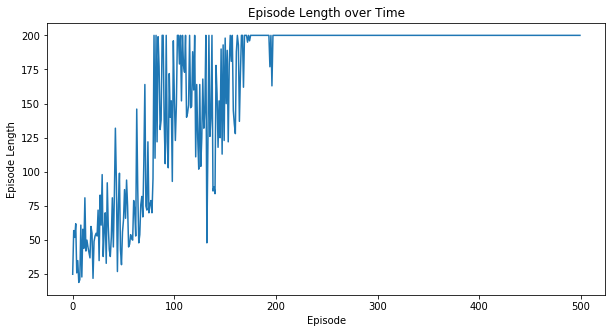

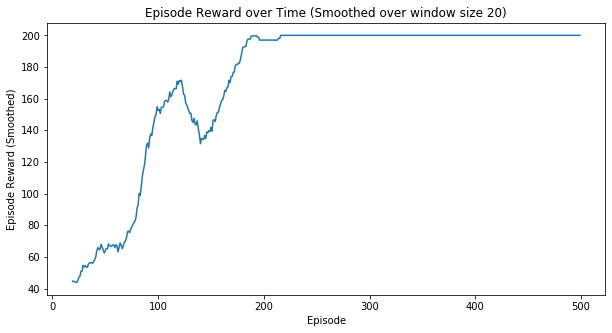

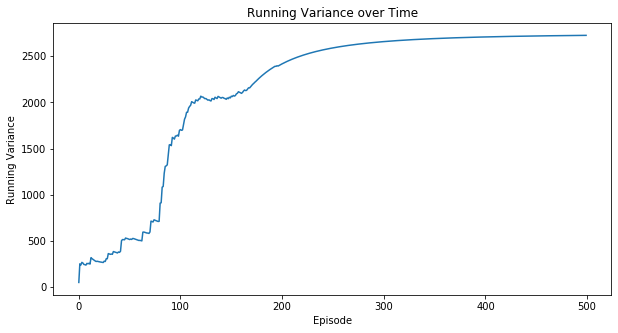

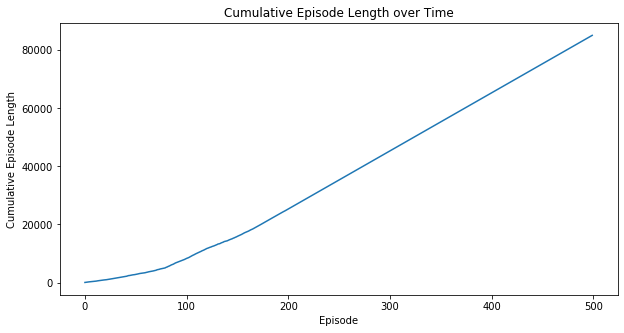

(<Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>)

In [11]:
plot_pgresults(stats)